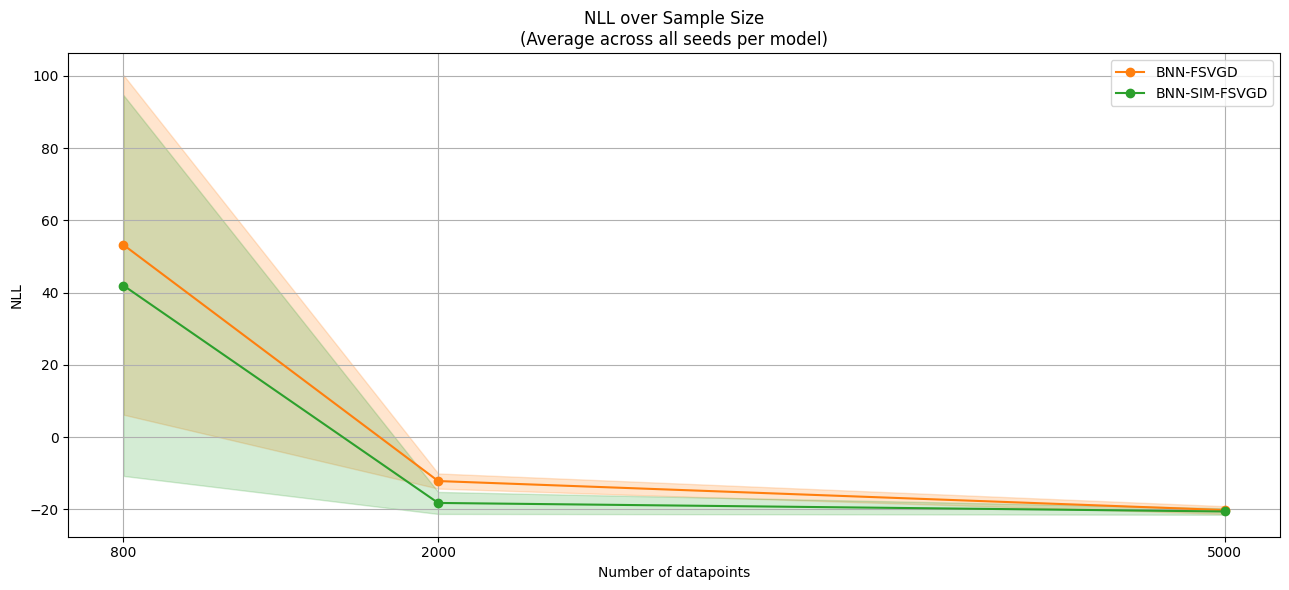

In [23]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")


# Initialize wandb API
api = wandb.Api()

# Replace 'your-entity' with your actual wandb entity
project = 'policy_testing_full_v9'

# Filter runs where 'ctrl_diff_weight' == 0.3
runs = api.runs(f'{project}', filters={"config.ctrl_diff_weight": 0.3})

# Prepare data storage
data = []

for run in runs:
    # Get config variables
    config = run.config
    use_sim_model = config.get('use_sim_model')
    use_sim_prior = config.get('use_sim_prior')
    random_seed = config.get('random_seed')
    num_offline_collected_transitions = config.get('num_offline_collected_transitions')
    run_id = run.id

    # Ensure all required config variables are present
    if None in [use_sim_model, use_sim_prior, random_seed, num_offline_collected_transitions]:
        raise Warning(f'Missing config for run: {run_id}')
        continue  # Skip runs with missing config

    # Get the history (metrics logged during the run)
    history = run.history(keys=['x_axis/bnn_step', 'regression_model_training/eval_nll'], pandas=True)

    # Check if history is empty
    if history.empty:
        raise Warning(f'No history for run: {run_id}')
        continue

    # Get the value at the maximum 'x_axis/bnn_step'
    max_step = history['x_axis/bnn_step'].max()
    last_nll = history.loc[history['x_axis/bnn_step'] == max_step, 'regression_model_training/eval_nll'].values

    if len(last_nll) == 0:
        raise Warning(f'No eval_nll at max step for run: {run_id}')
        continue  # Skip if no 'eval_nll' at max step

    last_nll = last_nll[0]

    # Append to data
    data.append({
        'use_sim_model': use_sim_model,
        'use_sim_prior': use_sim_prior,
        'random_seed': random_seed,
        'num_offline_collected_transitions': num_offline_collected_transitions,
        'eval_nll': last_nll
    })

# Convert data to DataFrame
df = pd.DataFrame(data)

# Map the models according to your specifications
def classify_model(row):
    if row['use_sim_model'] == 1 and row['use_sim_prior'] == 0:
        return 'SIM-MODEL'
    elif row['use_sim_model'] == 0 and row['use_sim_prior'] == 1:
        return 'BNN-SIM-FSVGD'
    elif row['use_sim_model'] == 0 and row['use_sim_prior'] == 0:
        return 'BNN-FSVGD'
    else:
        raise Warning(f'Unknown configuration: {row}')
        return None  # Exclude other configurations

df['Model'] = df.apply(classify_model, axis=1)

# Filter out runs that do not match any of the specified models
df = df[df['Model'].notnull()]

# Define the sample sizes and seeds of interest
sample_sizes = [800, 2000, 5000]
seeds = [42, 9126, 1913244]

# Filter data for the specified sample sizes and seeds
df = df[df['num_offline_collected_transitions'].isin(sample_sizes)]
df = df[df['random_seed'].isin(seeds)]

# Group data by Model and Sample Size
grouped = df.groupby(['Model', 'num_offline_collected_transitions'])

# Calculate mean, std, and standard error of 'eval_nll' for each group
stats = grouped['eval_nll'].agg(['mean', 'std', 'count']).reset_index()
stats['sem'] = stats['std'] / np.sqrt(stats['count'])

# Plotting
plt.figure(figsize=(10, 6))
models = ['SIM-MODEL', 'BNN-FSVGD', 'BNN-SIM-FSVGD']
colors = plt.get_cmap('tab10').colors
color_dict = dict(zip(models, colors))

for model in ['BNN-FSVGD', 'BNN-SIM-FSVGD']:
    model_data = stats[stats['Model'] == model]
    # Sort the data by sample size for proper plotting
    model_data = model_data.sort_values('num_offline_collected_transitions')

    # Plot mean line
    plt.plot(
        model_data['num_offline_collected_transitions'],
        model_data['mean'],
        label=model,
        color=color_dict[model],
        marker='o'
    )

    # Fill between mean ± SEM
    plt.fill_between(
        model_data['num_offline_collected_transitions'],
        model_data['mean'] - model_data['sem'],
        model_data['mean'] + model_data['sem'],
        color=color_dict[model],
        alpha=0.2
    )

plt.xlabel('Number of datapoints')
plt.ylabel('NLL')
plt.title('NLL over Sample Size\n(Average across all seeds per model)')
plt.xticks(sample_sizes)
plt.legend()
plt.grid(True)
current_size = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(current_size[0]*1.3, current_size[1])
plt.tight_layout()
plt.show()


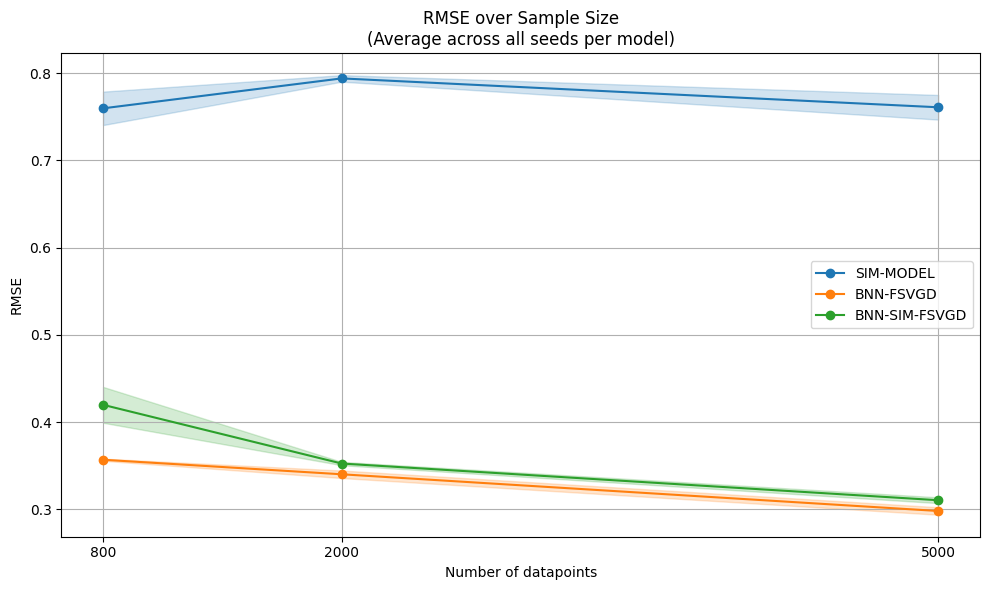

In [16]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")


# Initialize wandb API
api = wandb.Api()

# Replace 'your-entity' with your actual wandb entity
project = 'policy_testing_full_v9'

# Filter runs where 'ctrl_diff_weight' == 0.3
runs = api.runs(f'{project}', filters={"config.ctrl_diff_weight": 0.3})

# Prepare data storage
data = []

for run in runs:
    # Get config variables
    config = run.config
    use_sim_model = config.get('use_sim_model')
    use_sim_prior = config.get('use_sim_prior')
    random_seed = config.get('random_seed')
    num_offline_collected_transitions = config.get('num_offline_collected_transitions')
    run_id = run.id

    # Ensure all required config variables are present
    if None in [use_sim_model, use_sim_prior, random_seed, num_offline_collected_transitions]:
        raise Warning(f'Missing config for run: {run_id}')
        continue  # Skip runs with missing config

    # Get the history (metrics logged during the run)
    history = run.history(keys=['x_axis/bnn_step', 'regression_model_training/eval_rmse'], pandas=True)

    # Check if history is empty
    if history.empty:
        raise Warning(f'No history for run: {run_id}')
        continue

    # Get the value at the maximum 'x_axis/bnn_step'
    max_step = history['x_axis/bnn_step'].max()
    last_rmse = history.loc[history['x_axis/bnn_step'] == max_step, 'regression_model_training/eval_rmse'].values

    if len(last_rmse) == 0:
        raise Warning(f'No eval_nll at max step for run: {run_id}')
        continue  # Skip if no 'eval_rmse' at max step

    last_rmse = last_rmse[0]

    # Append to data
    data.append({
        'use_sim_model': use_sim_model,
        'use_sim_prior': use_sim_prior,
        'random_seed': random_seed,
        'num_offline_collected_transitions': num_offline_collected_transitions,
        'eval_rmse': last_rmse
    })

# Convert data to DataFrame
df = pd.DataFrame(data)

# Map the models according to your specifications
def classify_model(row):
    if row['use_sim_model'] == 1 and row['use_sim_prior'] == 0:
        return 'SIM-MODEL'
    elif row['use_sim_model'] == 0 and row['use_sim_prior'] == 1:
        return 'BNN-SIM-FSVGD'
    elif row['use_sim_model'] == 0 and row['use_sim_prior'] == 0:
        return 'BNN-FSVGD'
    else:
        raise Warning(f'Unknown configuration: {row}')
        return None  # Exclude other configurations

df['Model'] = df.apply(classify_model, axis=1)

# Filter out runs that do not match any of the specified models
df = df[df['Model'].notnull()]

# Define the sample sizes and seeds of interest
sample_sizes = [800, 2000, 5000]
seeds = [42, 9126, 1913244]

# Filter data for the specified sample sizes and seeds
df = df[df['num_offline_collected_transitions'].isin(sample_sizes)]
df = df[df['random_seed'].isin(seeds)]

# Group data by Model and Sample Size
grouped = df.groupby(['Model', 'num_offline_collected_transitions'])

# Calculate mean, std, and standard error of 'eval_rmse' for each group
stats = grouped['eval_rmse'].agg(['mean', 'std', 'count']).reset_index()
stats['sem'] = stats['std'] / np.sqrt(stats['count'])

# Plotting
plt.figure(figsize=(10, 6))
models = ['SIM-MODEL', 'BNN-FSVGD', 'BNN-SIM-FSVGD']
colors = plt.get_cmap('tab10').colors
color_dict = dict(zip(models, colors))

for model in ['SIM-MODEL', 'BNN-FSVGD', 'BNN-SIM-FSVGD']:
    model_data = stats[stats['Model'] == model]
    # Sort the data by sample size for proper plotting
    model_data = model_data.sort_values('num_offline_collected_transitions')

    # Plot mean line
    plt.plot(
        model_data['num_offline_collected_transitions'],
        model_data['mean'],
        label=model,
        color=color_dict[model],
        marker='o'
    )

    # Fill between mean ± SEM
    plt.fill_between(
        model_data['num_offline_collected_transitions'],
        model_data['mean'] - model_data['sem'],
        model_data['mean'] + model_data['sem'],
        color=color_dict[model],
        alpha=0.2
    )

plt.xlabel('Number of datapoints')
plt.ylabel('RMSE')
plt.title('RMSE over Sample Size\n(Average across all seeds per model)')
plt.xticks(sample_sizes)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
